This notebook is a tool used to implement Sentiment data into my S&P 500 Model. It uses Natural Language Processing to classify whether market sentiment is positive, negative, or neutral for each day. It will do this by using a pre-trained model called FINBERT to examine headlines and classify them.

In [6]:
import time
from polygon import RESTClient
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

Below is a function that will classify each headline as "positive", "negative" or "neutral".

In [7]:

print("Loading FinBERT model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

#Here is a function to generate the sentiment scores:
def get_sentiment(text):
    
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    
    with torch.no_grad():
        outputs = model(**inputs)
        
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_class_idx = torch.argmax(probabilities, dim=1).item()
    
    sentiment_labels = ["Positive", "Negative", "Neutral"]
    predicted_sentiment = sentiment_labels[predicted_class_idx]
    
    return predicted_sentiment





Loading FinBERT model and tokenizer...


In [8]:
#Set the date range and ticker info to scan through:
start_date = "2025-01-01"
end_date = "2025-8-11"
ticker = "SPY"

In [9]:
#Scan through the date range and add sentiment scores for each date:

client = RESTClient(api_key="auN6QWdaBLSjqACwM2dU_3Elu8DRHfAo")
print(f"Fetching news sentiment for {ticker} from {start_date} to {end_date}...")


sentiment_data = []

for day in pd.date_range(start=start_date, end=end_date):
    try:
        # Fetch up to 100 news articles for the day
        daily_news = list(client.list_ticker_news(ticker, published_utc=day.strftime("%Y-%m-%d"), limit=100))
        daily_sentiment_counts = {
            'date': day.strftime("%Y-%m-%d"),
            'positive': 0,
            'negative': 0,
            'neutral': 0
        }
        
        for article in daily_news:
            sentiment = get_sentiment(article.title)
            
            if sentiment == 'Positive':
                daily_sentiment_counts['positive'] += 1
            elif sentiment == 'Negative':
                daily_sentiment_counts['negative'] += 1
            elif sentiment == 'Neutral':
                daily_sentiment_counts['neutral'] += 1

        sentiment_data.append(daily_sentiment_counts)
        print(f"Processed news for: {day.strftime('%Y-%m-%d')}")
        
    except Exception as e:
        print(f"Error fetching news for {day.strftime('%Y-%m-%d')}: {e}")
    



Fetching news sentiment for SPY from 2025-01-01 to 2025-8-11...
Processed news for: 2025-01-01
Processed news for: 2025-01-02
Processed news for: 2025-01-03
Processed news for: 2025-01-04
Processed news for: 2025-01-05
Processed news for: 2025-01-06
Processed news for: 2025-01-07
Processed news for: 2025-01-08
Processed news for: 2025-01-09
Processed news for: 2025-01-10
Processed news for: 2025-01-11
Processed news for: 2025-01-12
Processed news for: 2025-01-13
Processed news for: 2025-01-14
Processed news for: 2025-01-15
Processed news for: 2025-01-16
Processed news for: 2025-01-17
Processed news for: 2025-01-18
Processed news for: 2025-01-19
Processed news for: 2025-01-20
Processed news for: 2025-01-21
Processed news for: 2025-01-22
Processed news for: 2025-01-23
Processed news for: 2025-01-24
Processed news for: 2025-01-25
Processed news for: 2025-01-26
Processed news for: 2025-01-27
Processed news for: 2025-01-28
Processed news for: 2025-01-29
Processed news for: 2025-01-30
Proces

Now that the we have all of our sentiments I will create a dataframe to export into my S&P500 model dataset. Because this is time series data, I will make sure to aggregate the scores for friday, saturday and sunday into one row. This is for formatting purposes and also so that the row for the following monday is seeing all of the information that came in over the weekend.

In [10]:

df_sentiment = pd.DataFrame(sentiment_data)
df_sentiment['date'] = pd.to_datetime(df_sentiment['date'])
df_sentiment['combined_date'] = df_sentiment['date']
df_sentiment.loc[df_sentiment['date'].dt.weekday.isin([5, 6]), 'combined_date'] = df_sentiment['date'] - pd.to_timedelta(df_sentiment['date'].dt.weekday - 4, unit='D')
df_aggregated = df_sentiment.drop(columns=['date']).groupby('combined_date').sum()
print("\nDataFrame with weekend data combined into Fridays:")
print(df_aggregated.head())



DataFrame with weekend data combined into Fridays:
               positive  negative  neutral
combined_date                             
2025-01-01            0         0        1
2025-01-02            1         1        1
2025-01-03            0         0        1
2025-01-06            1         0        0
2025-01-07            1         1        0


In [11]:
df_aggregated.to_csv('sentimentdata.csv')


Generating and saving plot...


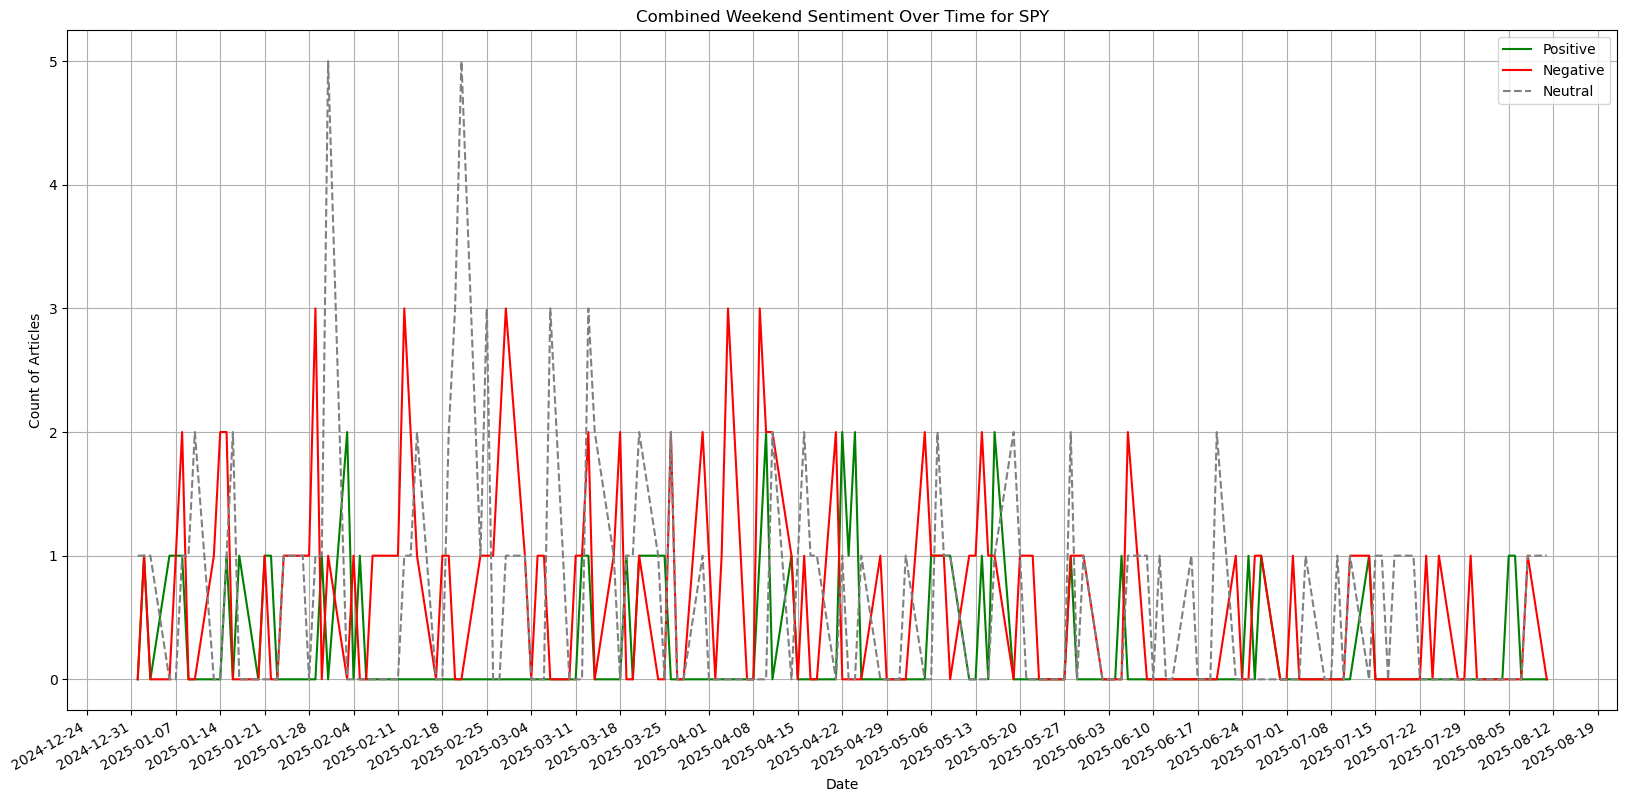

In [12]:

print("\nGenerating and saving plot...")
plt.figure(figsize=(20, 10))
plt.plot(df_aggregated['positive'], label='Positive', color='green')
plt.plot(df_aggregated['negative'], label='Negative', color='red')
plt.plot(df_aggregated['neutral'], label='Neutral', color='grey', linestyle='--')
plt.title(f'Combined Weekend Sentiment Over Time for {ticker}')
plt.xlabel('Date')
plt.ylabel('Count of Articles')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.savefig('combined_sentiment_over_time.png')
plt.show()
